# **Guinea Pig Breed Classification**

# Paths and Libraries
NB: This notebook is designed specifically to run from Google Colab, but you are free to run it from other platforms nonetheless.

While in Google Drive, make sure you have already duplicated the following folders into a subfolder 'cavy_breed_clf' under your 'Colab Notebooks' folder from my [repository](https://github.com/ringoshin/cavy_breed_clf):


* /data
* /images
* /lib




In [0]:
%load_ext autoreload
%autoreload 2

In [2]:
pwd

'/content'

In [3]:
# for Google Colab only: Mount my Google Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# for Google Colab only: Navigate to my snaug project folder
#cd 'My Drive/Colab Notebooks/cavy_breed_clf'

In [0]:
# A nifty OOP path management library
from pathlib import Path

In [0]:
proj_base = Path('/gdrive/My Drive/Colab Notebooks/cavy_breed_clf/')
proj_data = proj_base/'data'
proj_lib = proj_base/'lib'
proj_images = proj_base/'images'

# Copy Image Folder to Colab VM
You are strongly encouraged to copy the 'images' folder from your Google Drive directly into Colab VM's drive. It is my understanding that file I/O can be utterly slow between the two, especially so when compounded by reading all 1600+ images repeatedly from this notebook.

NB: The one-time copying will take a while, about 5-10min.

In [0]:
!mkdir images

In [0]:
!cp -r "{proj_images}" .

In [8]:
!ls -al images

total 88
drwxr-xr-x 7 root root  4096 Dec 31 18:01 .
drwxr-xr-x 1 root root  4096 Dec 31 17:48 ..
drwx------ 2 root root 28672 Dec 31 17:58 Abyssinian
drwx------ 2 root root 20480 Dec 31 17:52 American
drwx------ 2 root root  4096 Dec 31 18:01 new_samples
drwx------ 2 root root 12288 Dec 31 17:54 Silkie
drwx------ 2 root root 12288 Dec 31 18:00 Skinny


# Append the path
Append the path to the project base folder '/Colab Notebooks/cavy_breed_clf' on Google Drive. This will ensure the library functions under '/lib' can be imported.

In [9]:
import sys
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [10]:
#sys.path.append("/gdrive/My Drive/Colab Notebooks/cavy_breed_clf/lib")
sys.path.append(str(proj_base))
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/gdrive/My Drive/Colab Notebooks/cavy_breed_clf']

# Load the Libraries

In [0]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [12]:
from lib.data_common import (target_names, Read_and_Process_Image, 
                             Load_and_Split)
from lib.ml_common import (Save_Model_Data, Load_Model_Data,
                           Vanilla_ML_Run, Vanilla_ML_Predict, Predict_and_Report,
                           Vanilla_ML_Run_CV, Show_Confusion_Matrix)
from lib.ml_common import (Plot_Precision_Recall_Curve, Plot_ROC_Curve,
                           Compare_Multiple_ROC_Curves, Compare_Multiple_PR_Curves)
from lib.nn_common import (Image_CNN_Multilayer, Image_CNN_Multilayer_Train,
                           Image_CNN_From_InceptionV3,
                           Image_CNN_From_InceptionV3_Train, Image_NN_Predict,
                           Image_NN_Predict_One, Image_NN_Predict_Random_Test_Images,
                           Image_NN_Predict_New_Samples,
                           Image_NN_Plt_Acc, Image_NN_Plt_Loss, 
                           Image_NN_Plt_Training, Image_NN_Plt_Validation,
                           Save_NN_Model_Data, Load_NN_Model_Data)

Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

%matplotlib inline

# Initialize Variables

In [14]:
# verify that the target/label names are imported correct
target_names

['Abyssinian', 'American', 'Silkie', 'Skinny']

In [0]:
# fix random seed for reproducibility
seed = 128
np.random.seed(seed)

# Image size for standardisation
image_shape = (150, 150)
input_shape = (-1, 150, 150, 3)
nrows = 150
ncolumns = 150

batch_size = 64

# Load and Split the Training, Validation and Testing Datasets
The function 'Load_and_Split' will perform two data preprocessing steps:
* transform images by resizing to (150,150) and flatten it to 1-d array, this will be the features aka X
* transform breed labels into one-hot encoding, this will be the target aka y

In [16]:
# Load pre-split data from training, validation and test data sets
print(">>> Loading data")
#X_train, y_train = Load_and_Split('data/cavy_data_train.csv', image_shape)
#X_val, y_val = Load_and_Split('data/cavy_data_val.csv', image_shape)
#X_test, y_test = Load_and_Split('data/cavy_data_test.csv', image_shape)
X_train, y_train = Load_and_Split(str(proj_data/'cavy_data_train.csv'), image_shape)
X_val, y_val = Load_and_Split(str(proj_data/'cavy_data_val.csv'), image_shape)
X_test, y_test = Load_and_Split(str(proj_data/'cavy_data_test.csv'), image_shape)

>>> Loading data


In [17]:
# sanity checks
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1043, 67500) (1043, 4)
(261, 67500) (261, 4)
(327, 67500) (327, 4)


In [18]:
X_train[:3]

array([[163, 179, 196, ..., 232, 237, 252],
       [  1,  65,  66, ..., 204, 180, 157],
       [ 64,  62,  74, ...,  44, 105, 153]], dtype=uint8)

In [19]:
y_train[:3]

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

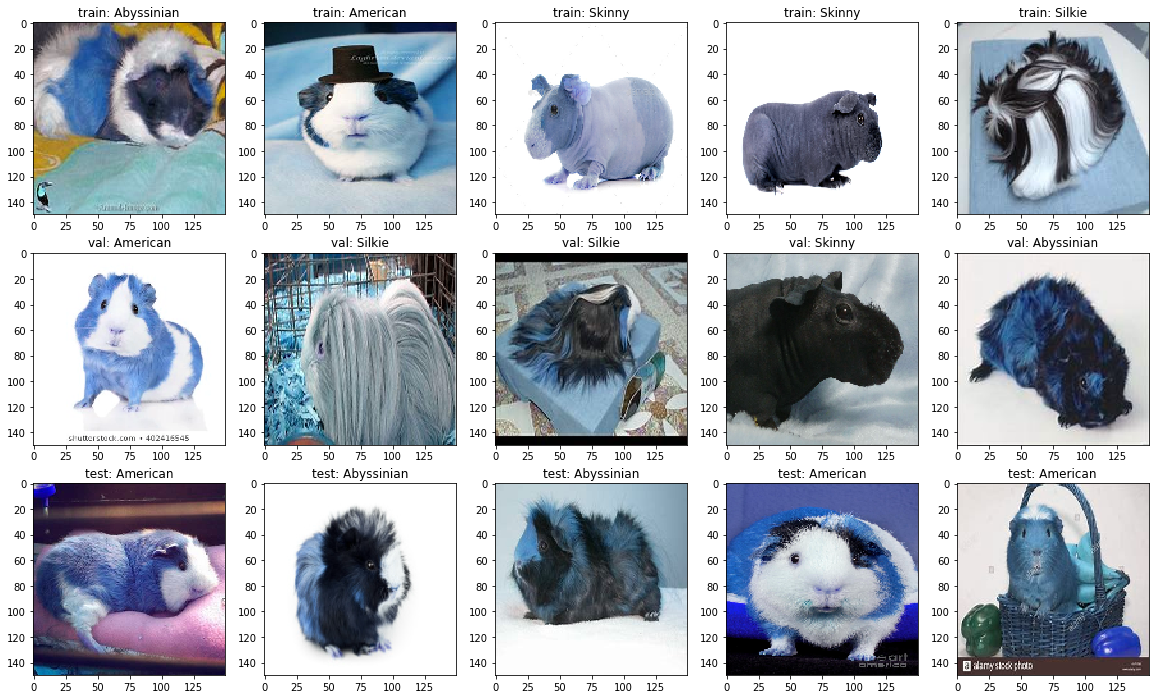

In [21]:
# visual check random images with their assigned labels from each dataset
plt.figure(figsize=(20,12))
for i, (dataset, X, y) in enumerate([('train', X_train, y_train),
                            ('val', X_val, y_val),
                            ('test', X_test, y_test)]):
    random_idx = np.random.choice(range(len(X)), 5, replace=False)
    for j, idx in enumerate(random_idx, start=1):
        plt.subplot(3, 5, i*5+j)
        _ = plt.title(dataset + ': ' + target_names[np.argmax(y[idx])])
        _ = plt.imshow(X[idx].reshape(150,150,3))

# Create Baseline Model using Classical Classifiers
Let's start off by training the following models using only their default settings and see how they will perform:
* Dummy classifier
* Logistic Regression (our baseline)
* Gaussian Naive Bayes
* Random Forest

We'll also be using ['One versus Rest'](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) strategy from scikit-learn library.

In [0]:
# List of selected models that will learn to predict each class against the others
clf_list = {'OVR Dummy': OneVsRestClassifier(DummyClassifier(), n_jobs=-1),
            'OVR Logistic Regression': OneVsRestClassifier(LogisticRegression(multi_class='ovr', n_jobs=-1), n_jobs=-1),
#            'OVR K-Nearest Neighbor': KNeighborsClassifier(n_neighbors=5),
            'OVR Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=-1),
#            'OVR SVM': LinearSVC(),
            'OVR Random Forest': OneVsRestClassifier(RandomForestClassifier(n_estimators=100), n_jobs=-1)
            }

In [23]:
# Train and predict using vanilla classical models to set a baseline 
# for latter deep learning models
clf_list = Vanilla_ML_Run(clf_list, X_train, y_train)
print('> done')

>> Starting 4 vanilla ML runs

 > Training OVR Dummy
 > Training OVR Logistic Regression


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 > Training OVR Naive Bayes
 > Training OVR Random Forest

> done


In [24]:
%cd "{proj_base}"

/gdrive/My Drive/Colab Notebooks/cavy_breed_clf


In [0]:
# Save all models for future multiple prediction runs
Save_Model_Data(clf_list['OVR Dummy'], 'ovr_dummy_v2')
Save_Model_Data(clf_list['OVR Logistic Regression'], 'ovr_logistic_regression_ovr_v2')
Save_Model_Data(clf_list['OVR Naive Bayes'], 'ovr_naive_bayes_v2')
Save_Model_Data(clf_list['OVR Random Forest'], 'ovr_random_foreset_n_est-100_v2')

In [0]:
# Load saved models
clf_list['OVR Dummy'] = Load_Model_Data('ovr_dummy_v2')
clf_list['OVR Logistic Regression'] = Load_Model_Data('ovr_logistic_regression_ovr_v2')
clf_list['OVR Naive Bayes'] = Load_Model_Data('ovr_naive_bayes_v2')
clf_list['OVR Random Forest'] = Load_Model_Data('ovr_random_foreset_n_est-100_v2')

In [27]:
%cd '/content'

/content


# Compare Classical Model Performances
Scikit-learn ['classification report'](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and ['confusion matrix'](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) should always be your goto tools for reviewing classification models. On top of that, we can also analyze visually through ['Multi-class Precision-Recall curves'](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#in-multi-label-settings) and ['Multi-class ROC curves'](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem).

NB: As we are dealing with moderately imbalanced classes, you might like to take a look at the following articles on [PR vs ROC curves](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba) and [micro vs macro averages](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin).

In [0]:
# dictionary to keep track of predictions for all trained classifiers
y_score_dict = dict()

# OVR Dummy Classifier

In [0]:
clf = clf_list['OVR Dummy']
clf_name = 'OVR Dummy'
y_score = clf.predict_proba(X_val)
y_score_dict[clf_name] = y_score

In [30]:
clf_acc, clf_report, cf_matrix = Predict_and_Report(clf, X_val, y_val, target_names)
print("{}'s accuracy: {:.2%}".format(clf_name, clf_acc))
print()
print("  > Classification report:")
print(clf_report)

OVR Dummy's accuracy: 9.20%

  > Classification report:
              precision    recall  f1-score   support

  Abyssinian       0.32      0.34      0.33        88
    American       0.31      0.33      0.32        83
      Silkie       0.15      0.19      0.17        43
      Skinny       0.12      0.11      0.11        47

   micro avg       0.26      0.27      0.26       261
   macro avg       0.23      0.24      0.23       261
weighted avg       0.25      0.27      0.26       261
 samples avg       0.17      0.27      0.20       261



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


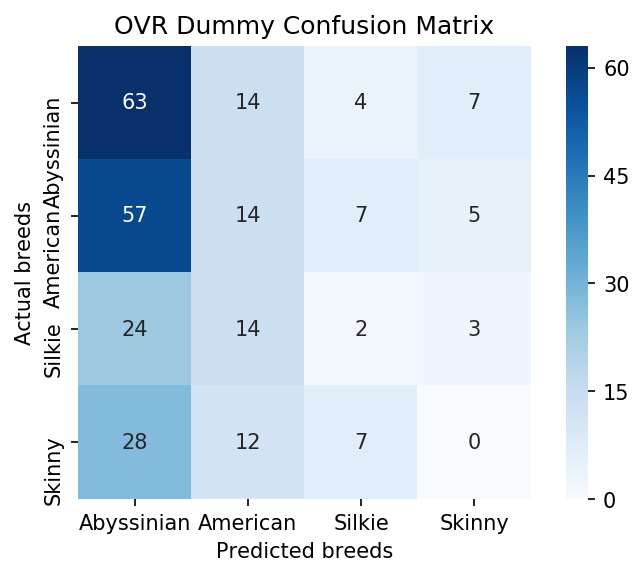

In [31]:
Show_Confusion_Matrix(cf_matrix, target_names, clf_name=clf_name)

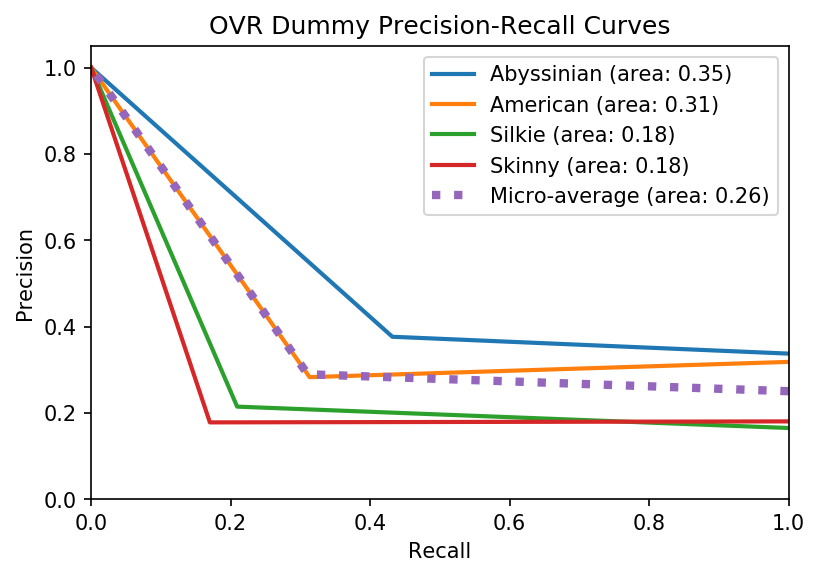

In [32]:
_ = Plot_Precision_Recall_Curve(y_val, y_score, target_names, clf_name=clf_name)

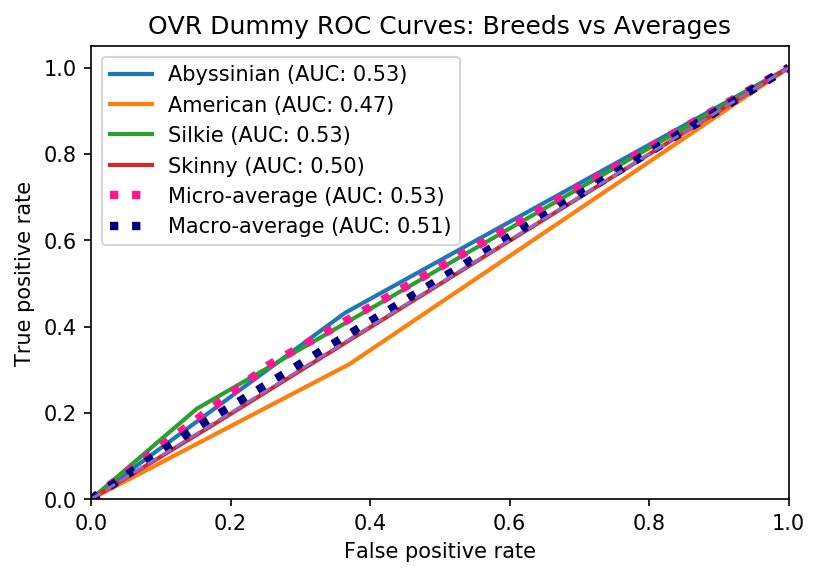

In [33]:
_ = Plot_ROC_Curve(y_val, y_score, target_names, clf_name=clf_name)

# OVR Logistic Regression

In [0]:
clf = clf_list['OVR Logistic Regression']
clf_name = 'OVR Logistic Regression'
y_score = clf.predict_proba(X_val)
y_score_dict[clf_name] = y_score

In [35]:
clf_acc, clf_report, cf_matrix = Predict_and_Report(clf, X_val, y_val, target_names)
print("{}'s accuracy: {:.2%}".format(clf_name, clf_acc))
print()
print("  > Classification report:")
print(clf_report)

OVR Logistic Regression's accuracy: 40.23%

  > Classification report:
              precision    recall  f1-score   support

  Abyssinian       0.58      0.55      0.56        88
    American       0.51      0.53      0.52        83
      Silkie       0.58      0.49      0.53        43
      Skinny       0.42      0.34      0.38        47

   micro avg       0.53      0.49      0.51       261
   macro avg       0.52      0.48      0.50       261
weighted avg       0.53      0.49      0.51       261
 samples avg       0.45      0.49      0.46       261



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


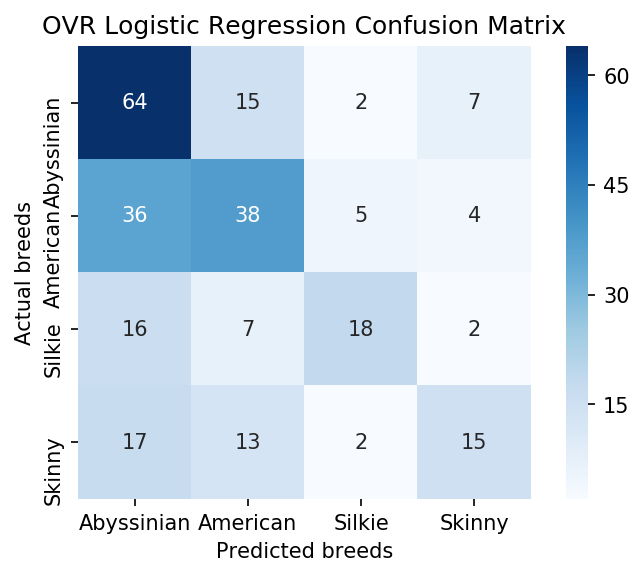

In [36]:
Show_Confusion_Matrix(cf_matrix, target_names, clf_name=clf_name)

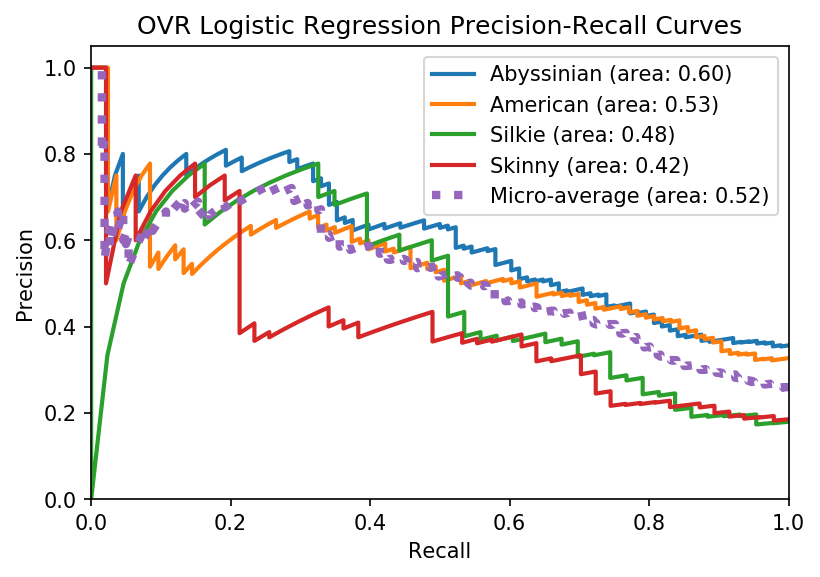

In [37]:
_ = Plot_Precision_Recall_Curve(y_val, y_score, target_names, clf_name=clf_name)

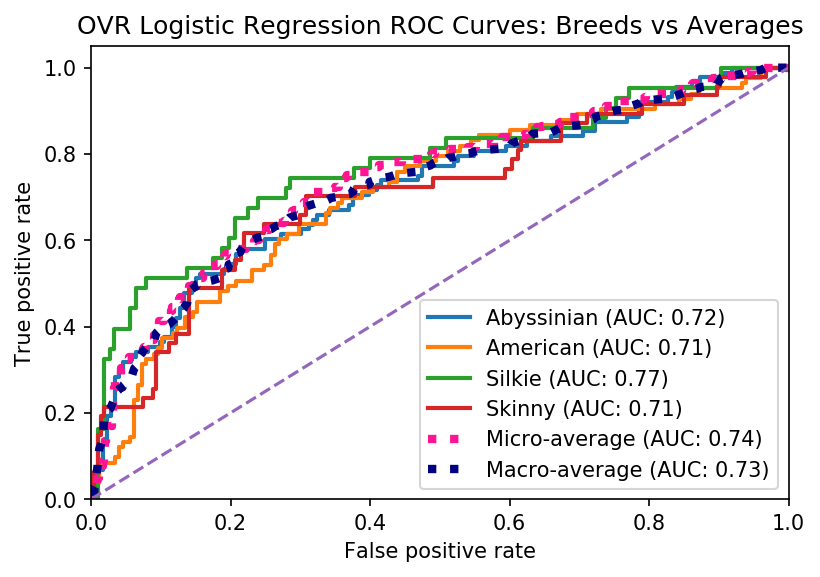

In [38]:
_ = Plot_ROC_Curve(y_val, y_score, target_names, clf_name=clf_name)

# OVR Naive Bayes

In [0]:
clf = clf_list['OVR Naive Bayes']
clf_name = 'OVR Naive Bayes'
y_score = clf.predict_proba(X_val)
y_score_dict[clf_name] = y_score

In [40]:
clf_acc, clf_report, cf_matrix = Predict_and_Report(clf, X_val, y_val, target_names)
print("{}'s accuracy: {:.2%}".format(clf_name, clf_acc))
print()
print("  > Classification report:")
print(clf_report)

OVR Naive Bayes's accuracy: 4.60%

  > Classification report:
              precision    recall  f1-score   support

  Abyssinian       0.43      0.59      0.50        88
    American       0.41      0.61      0.50        83
      Silkie       0.23      0.81      0.35        43
      Skinny       0.23      0.49      0.31        47

   micro avg       0.32      0.62      0.42       261
   macro avg       0.32      0.63      0.41       261
weighted avg       0.35      0.62      0.44       261
 samples avg       0.33      0.62      0.42       261



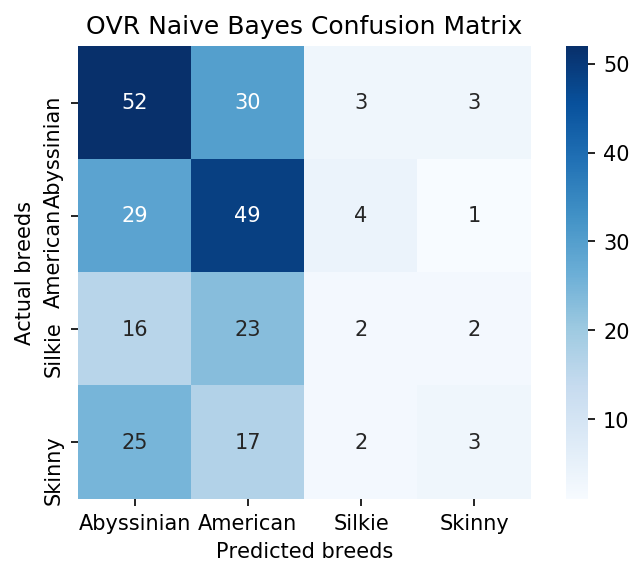

In [41]:
Show_Confusion_Matrix(cf_matrix, target_names, clf_name=clf_name)

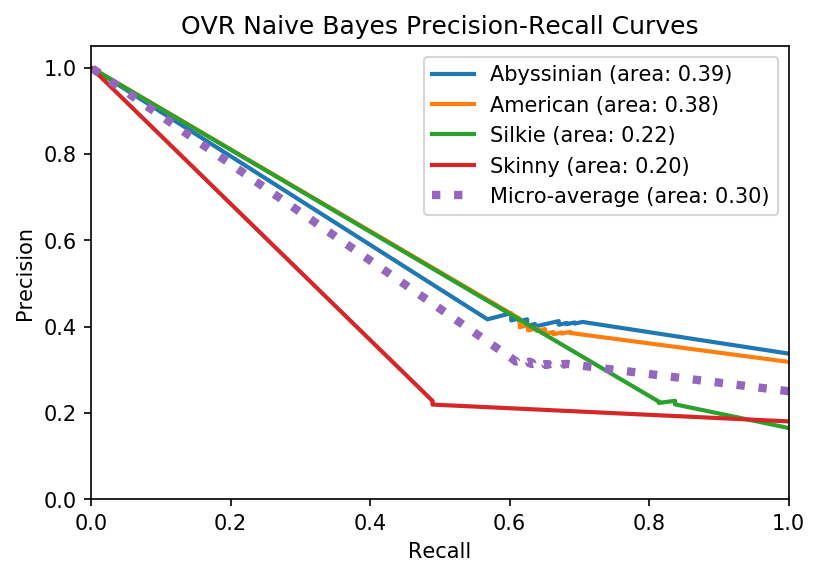

In [42]:
_ = Plot_Precision_Recall_Curve(y_val, y_score, target_names, clf_name=clf_name)

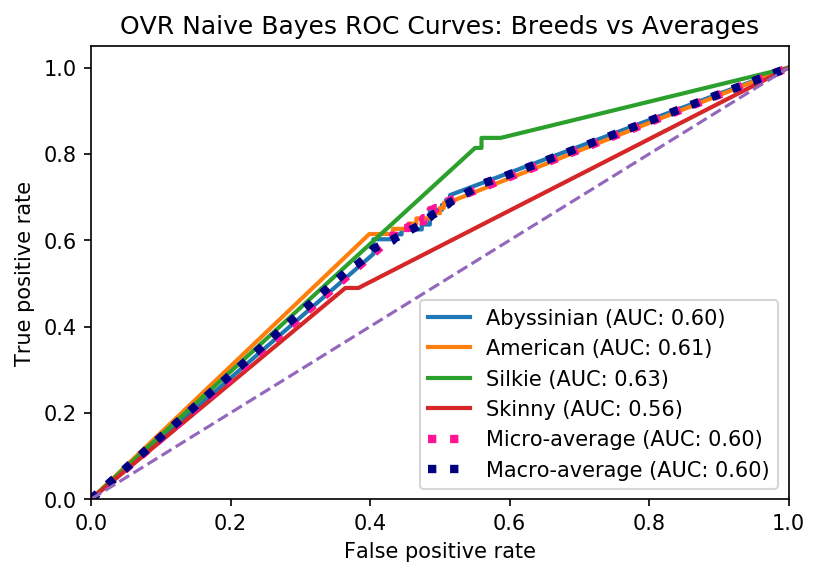

In [43]:
_ = Plot_ROC_Curve(y_val, y_score, target_names, clf_name=clf_name)

# OVR Random Forest

In [0]:
clf = clf_list['OVR Random Forest']
clf_name = 'OVR Random Forest'
y_score = clf.predict_proba(X_val)
y_score_dict[clf_name] = y_score

In [45]:
clf_acc, clf_report, cf_matrix = Predict_and_Report(clf, X_val, y_val, target_names)
print("{}'s accuracy: {:.2%}".format(clf_name, clf_acc))
print()
print("  > Classification report:")
print(clf_report)

OVR Random Forest's accuracy: 32.57%

  > Classification report:
              precision    recall  f1-score   support

  Abyssinian       0.92      0.39      0.54        88
    American       0.71      0.47      0.57        83
      Silkie       0.90      0.21      0.34        43
      Skinny       1.00      0.17      0.29        47

   micro avg       0.82      0.34      0.49       261
   macro avg       0.88      0.31      0.43       261
weighted avg       0.86      0.34      0.47       261
 samples avg       0.34      0.34      0.34       261



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


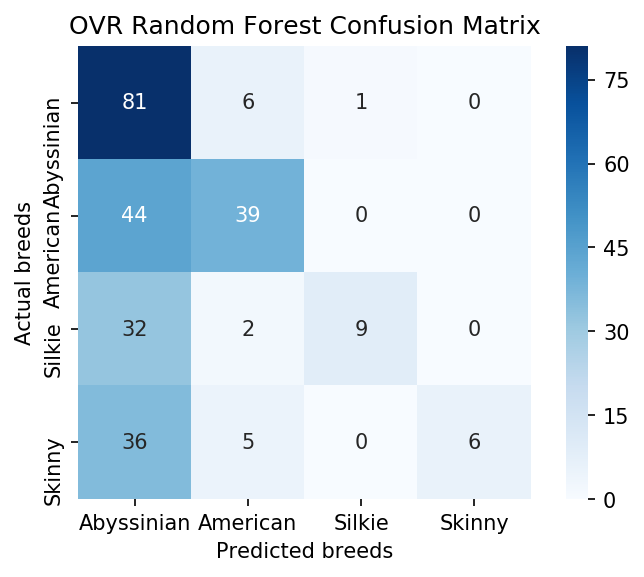

In [46]:
Show_Confusion_Matrix(cf_matrix, target_names, clf_name=clf_name)

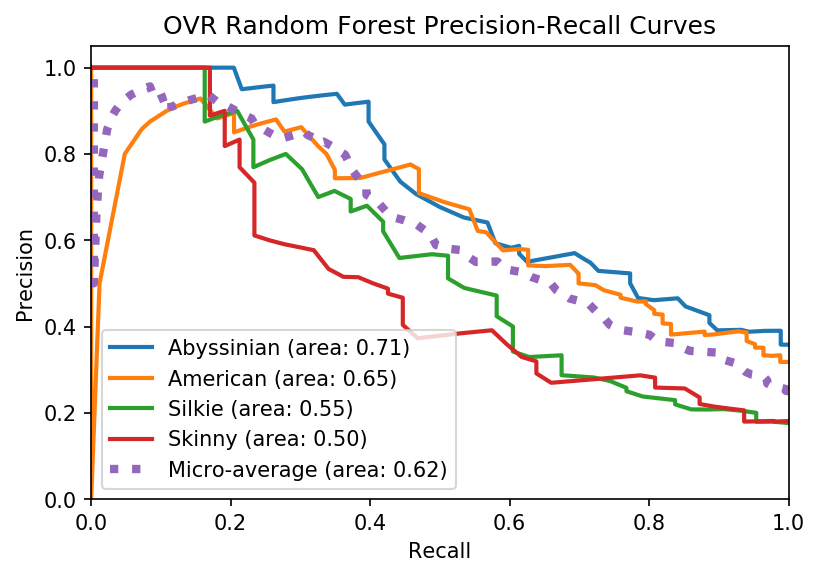

In [47]:
_ = Plot_Precision_Recall_Curve(y_val, y_score, target_names, clf_name=clf_name)

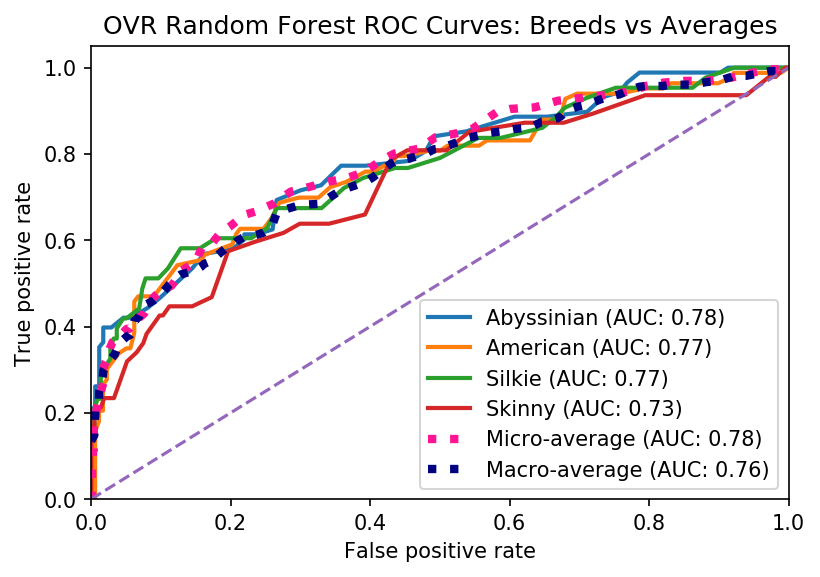

In [48]:
_ = Plot_ROC_Curve(y_val, y_score, target_names, clf_name=clf_name)

# Create a Multi-layer Image CNN model
The 'Image_CNN_Multilayer' function will create a multi-layer model that consists of 2-d convolutional and pooling layers. The model will then be trained from scratch for 100 epochs.

Techniques like 'image data augmentation' are being applied here. If you are unfamiliar, you can check it out [here](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) and [here](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/).

In [49]:
# Multilayer Image CNN

model_ml_cnn = Image_CNN_Multilayer(num_target=4, input_shape=(150,150,3))
print(model_ml_cnn.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0        

# Train a Multi-layer Image CNN Model

In [50]:
model_ml_cnn , history_ml_cnn = Image_CNN_Multilayer_Train(model_ml_cnn, 
                                     X_train.reshape(input_shape), 
                                     y_train,
                                     X_val.reshape(input_shape), 
                                     y_val, 
                                     epochs=100,
                                     batch_size=batch_size, 
                                     verbose=1)

>> Training multilayer image CNN
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





17/17 [==============================] - 17s 993ms/step - loss: 1.3651 - categorical_accuracy: 0.3290 - val_loss: 1.3371 - val_categorical_accuracy: 0.3372
Epoch 2/100
17/17 [==============================] - 6s 328ms/step - loss: 1.3193 - categorical_accuracy: 0.3306 - val_loss: 1.2853 - val_categorical_accuracy: 0.3372
Epoch 3/100
17/17 [==============================] - 6s 333ms/step - loss: 1.3013 - categorical_accuracy: 0.3447 - val_loss: 1.2875 - val_categorical_accuracy: 0.3563
Epoch 4/100
17/17 [==============================] - 6s 335ms/step - loss: 1.2872 - categorical_accuracy: 0.3454 - val_loss: 1.2753 - val_categorical_accuracy: 0.3563
Epoch 5/100
17/17 [==============================] - 6s 336ms/step - loss: 1.3022 - categorical_accuracy: 0.3390 - val_loss: 1.3320 - val_categorical_accuracy: 0.3448
Epoch 6/100
17/17 [==========

In [51]:
%cd "{proj_base}"

/gdrive/My Drive/Colab Notebooks/cavy_breed_clf


In [0]:
model_ml_cnn_name = 'cnn_multilayer_v2_epoch-100'

In [0]:
Save_NN_Model_Data(model_ml_cnn, history_ml_cnn, model_ml_cnn_name)

In [0]:
model_ml_cnn, history_ml_cnn = Load_NN_Model_Data(model_ml_cnn_name)

In [55]:
%cd '/content'

/content


# Review Multi-layer Image CNN Training and Validation Progress
As you can see, it is already more accurate than the best classical models. However, you will notice that from epoch 40 onwards, the training improves barely for both validation accuracy and loss. This model is likely overfitting.

In [56]:
results_ml_cnn = {k: history_ml_cnn.history[k][-1] for k in history_ml_cnn.history.keys()}
results_ml_cnn

{'categorical_accuracy': 0.7775647176763584,
 'loss': 0.5682542133194145,
 'val_categorical_accuracy': 0.674329502144079,
 'val_loss': 0.9125616408855979}

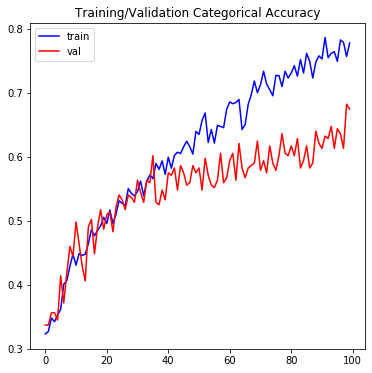

In [57]:
Image_NN_Plt_Acc(history_ml_cnn)

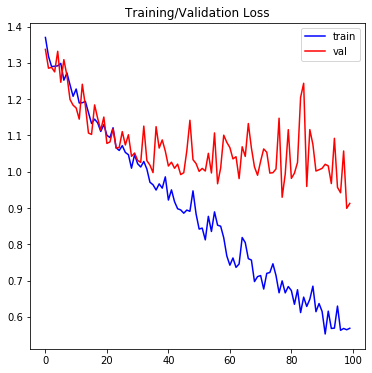

In [58]:
Image_NN_Plt_Loss(history_ml_cnn)

# Review Multi-layer Image CNN Performances
Let's look at the classification report, confusion matrix, PR curves and ROC curves.

In [59]:
clf_report_ml_cnn, cf_matrix_ml_cnn, y_pred_ml_cnn, y_pred_bool_ml_cnn = Image_NN_Predict(model_ml_cnn, 
                                                        X_val.reshape((input_shape)), 
                                                        y_val, 
                                                        target_names=target_names,
                                                        batch_size=batch_size, 
                                                        verbose=2)

>> Predicting on neural network
              precision    recall  f1-score   support

  Abyssinian       0.75      0.56      0.64        88
    American       0.60      0.75      0.67        83
      Silkie       0.57      0.63      0.60        43
      Skinny       0.83      0.81      0.82        47

    accuracy                           0.67       261
   macro avg       0.69      0.69      0.68       261
weighted avg       0.69      0.67      0.67       261

[[49 29  9  1]
 [ 7 62 11  3]
 [ 7  5 27  4]
 [ 2  7  0 38]]



In [0]:
y_score_dict['ML-CNN'] = y_pred_ml_cnn

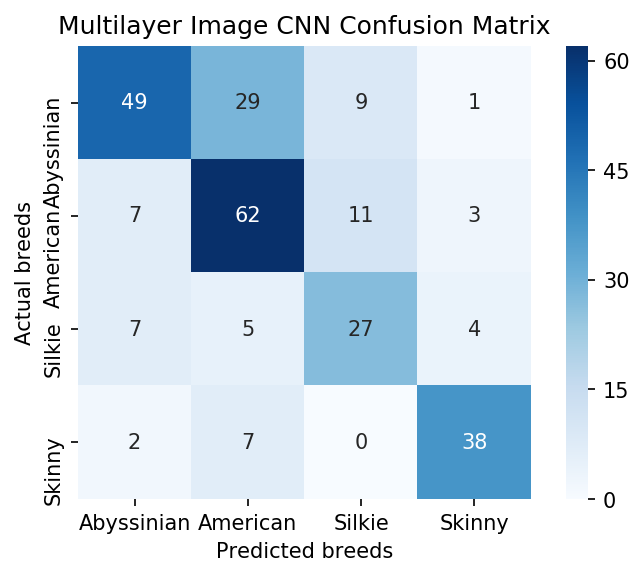

In [61]:
Show_Confusion_Matrix(cf_matrix_ml_cnn, target_names, clf_name="Multilayer Image CNN")

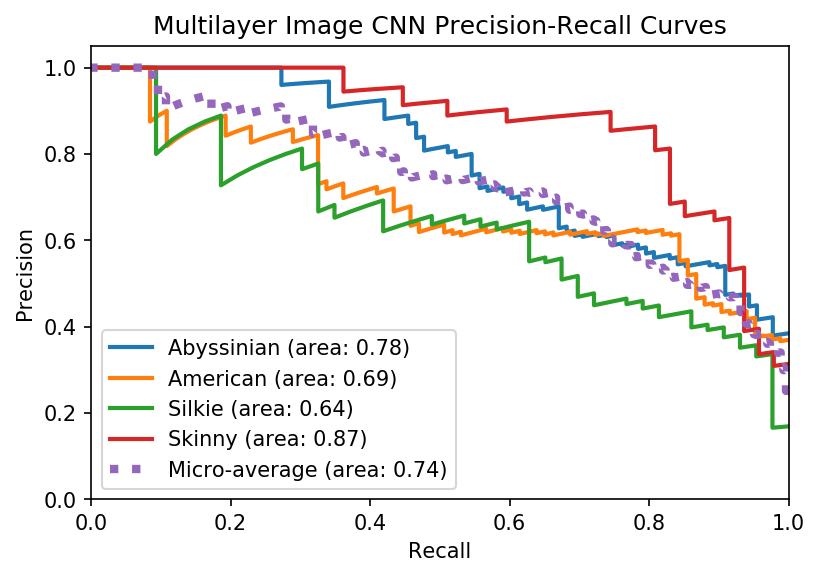

In [62]:
_ = Plot_Precision_Recall_Curve(y_val, y_pred_ml_cnn, target_names, clf_name="Multilayer Image CNN")

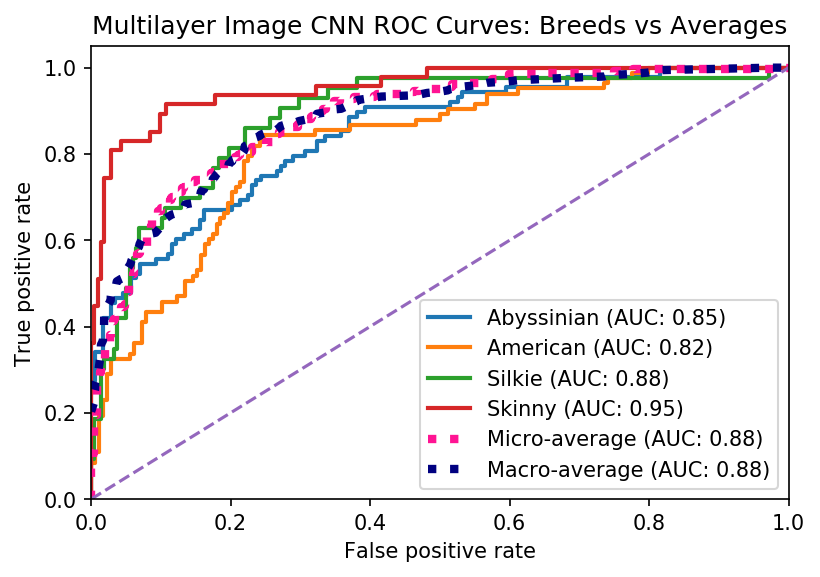

In [63]:
_ = Plot_ROC_Curve(y_val, y_pred_ml_cnn, target_names, clf_name="Multilayer Image CNN")

# Create a 2nd Image CNN Model using Transfer Learning from InceptionV3
This model is built using transfer learning technique as illustrated [here](https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes). It uses weights pretrained on [ImageNet](http://www.image-net.org/). For this specific model, I chose to freeze the first 230 layers.

In [0]:
# Transfer learning from InceptionV3, freezing 230 layers
model_inc_v3_230 = Image_CNN_From_InceptionV3(num_target=4, input_shape=(150,150,3))

In [99]:
model_inc_v3_230, history_inc_v3_230_1, history_inc_v3_230_2 = Image_CNN_From_InceptionV3_Train(model_inc_v3_230, 
                                     X_train.reshape((input_shape)), 
                                     y_train,
                                     X_val.reshape((input_shape)),
                                     y_val, 
                                     epochs=100,
                                     batch_size=batch_size, 
                                     freeze_layer=230,
                                     verbose=1)

>>> Training with pre-trained Inception v3
 >> Training model with new data
Epoch 1/100
 - 24s - loss: 5.4422 - categorical_accuracy: 0.3463 - val_loss: 3.3754 - val_categorical_accuracy: 0.4061
Epoch 2/100
 - 3s - loss: 1.1488 - categorical_accuracy: 0.5750 - val_loss: 1.2449 - val_categorical_accuracy: 0.6782
Epoch 3/100
 - 6s - loss: 0.9565 - categorical_accuracy: 0.6231 - val_loss: 6.6216 - val_categorical_accuracy: 0.3716
Epoch 4/100
 - 6s - loss: 0.9343 - categorical_accuracy: 0.6601 - val_loss: 1.9968 - val_categorical_accuracy: 0.6782
Epoch 5/100
 - 6s - loss: 0.9134 - categorical_accuracy: 0.6325 - val_loss: 2.2752 - val_categorical_accuracy: 0.6360
Epoch 6/100
 - 6s - loss: 0.7915 - categorical_accuracy: 0.6960 - val_loss: 1.3496 - val_categorical_accuracy: 0.7088
Epoch 7/100
 - 6s - loss: 0.6974 - categorical_accuracy: 0.7208 - val_loss: 2.0243 - val_categorical_accuracy: 0.7318
Epoch 8/100
 - 6s - loss: 0.8013 - categorical_accuracy: 0.6936 - val_loss: 2.5366 - val_categori

In [100]:
%cd "{proj_base}"

/gdrive/My Drive/Colab Notebooks/cavy_breed_clf


In [0]:
model_inc_v3_230_name = 'inceptionV3_tuned_freeze-230_sgd_v2_epoch-100'

In [0]:
Save_NN_Model_Data(model_inc_v3_230, history_inc_v3_230_2, model_inc_v3_230_name)

In [0]:
model_inc_v3_230, history_inc_v3_230 = Load_NN_Model_Data(model_inc_v3_230_name)

In [104]:
%cd "/content"

/content


# Review Pre-trained Image CNN Training and Validation Progress
In a similar vein, there are signs of overfitting too. Also, the wild swings could be due to a small dataset being used.

In [105]:
results_inc_v3_230 = {k: history_inc_v3_230.history[k][-1] for k in history_inc_v3_230.history.keys()}
results_inc_v3_230

{'categorical_accuracy': 0.987535953978907,
 'loss': 0.02753241116775705,
 'val_categorical_accuracy': 0.8237547895004009,
 'val_loss': 1.7909248587728916}

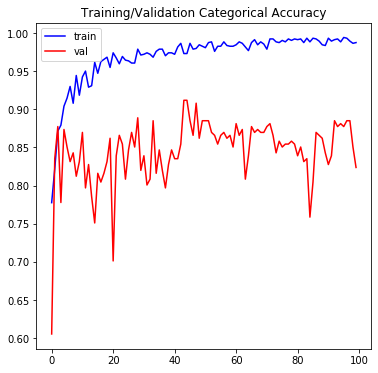

In [106]:
Image_NN_Plt_Acc(history_inc_v3_230)

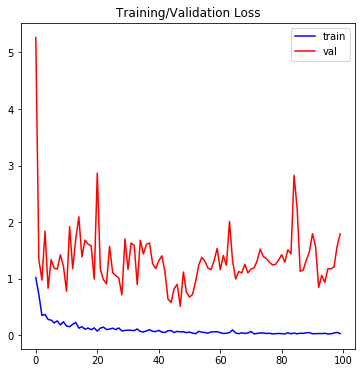

In [107]:
Image_NN_Plt_Loss(history_inc_v3_230)

# Review Pre-trained Image CNN Performances
Let's look at the classification report, confusion matrix, PR curves and ROC curves.

In [108]:
clf_report_inc_v3_230, cf_matrix_inc_v3_230, y_pred_inc_v3_230, y_bool_inc_v3_230 = Image_NN_Predict(model_inc_v3_230,
                                                    X_val.reshape(input_shape), 
                                                    y_val, 
                                                    target_names=target_names,
                                                    batch_size=batch_size, 
                                                    verbose=2)

>> Predicting on neural network
              precision    recall  f1-score   support

  Abyssinian       1.00      0.64      0.78        88
    American       0.66      0.99      0.79        83
      Silkie       0.94      0.79      0.86        43
      Skinny       0.98      0.91      0.95        47

    accuracy                           0.82       261
   macro avg       0.89      0.83      0.84       261
weighted avg       0.88      0.82      0.82       261

[[56 31  1  0]
 [ 0 82  0  1]
 [ 0  9 34  0]
 [ 0  3  1 43]]



In [0]:
y_score_dict['InceptionV3_230'] = y_pred_inc_v3_230

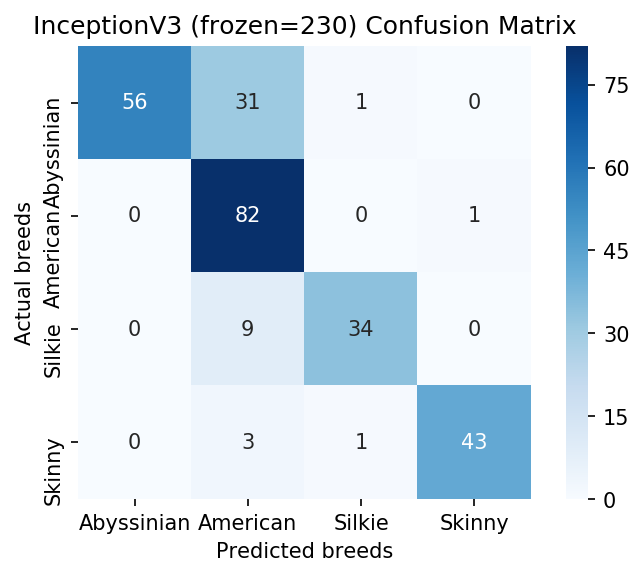

In [110]:
Show_Confusion_Matrix(cf_matrix_inc_v3_230, target_names, clf_name="InceptionV3 (frozen=230)")

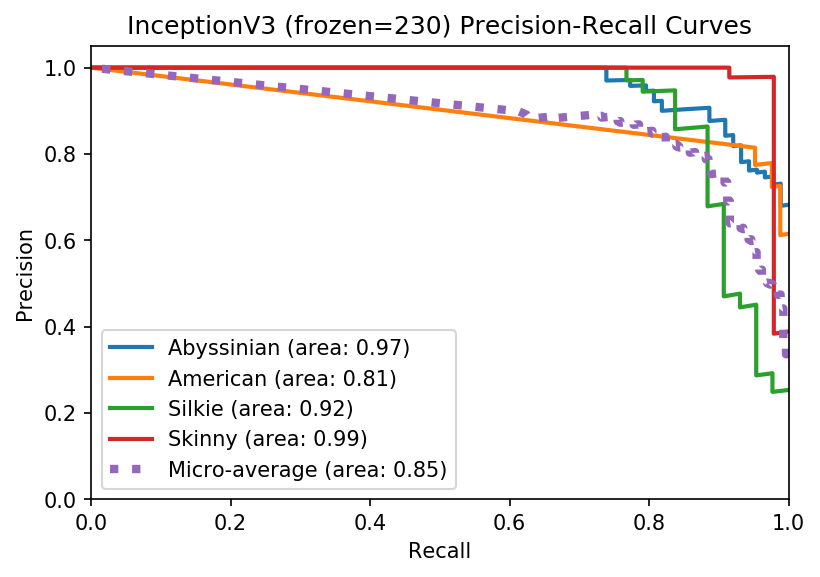

In [111]:
_ = Plot_Precision_Recall_Curve(y_val, y_pred_inc_v3_230, target_names, clf_name="InceptionV3 (frozen=230)")

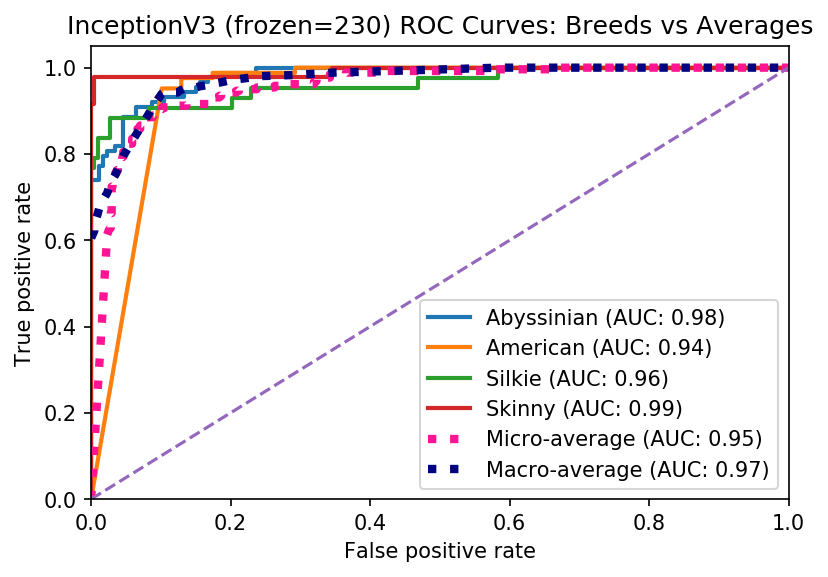

In [112]:
_ = Plot_ROC_Curve(y_val, y_pred_inc_v3_230, target_names, clf_name="InceptionV3 (frozen=230)")

# Compare PR Curves and ROC Curves of Different Models
Let's compare all the trained classifiers. The winner is clear, isn't it?


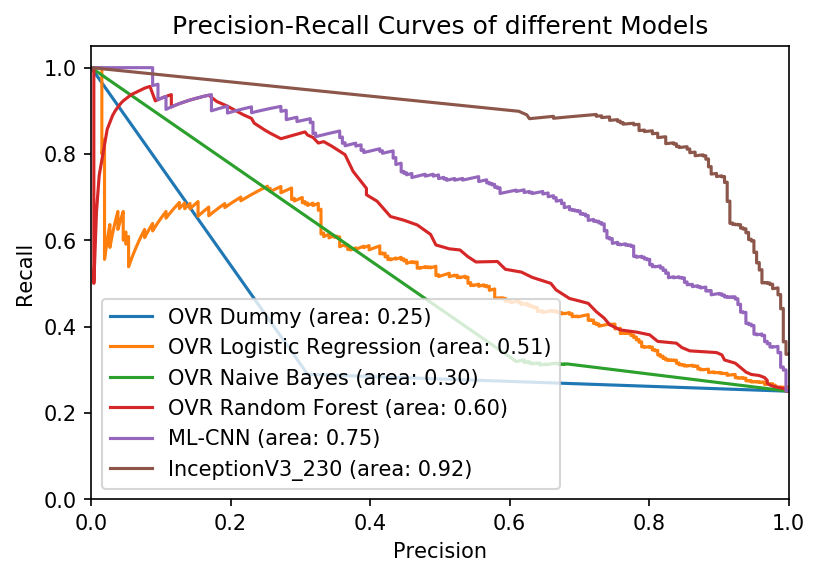

In [113]:
Compare_Multiple_PR_Curves(y_val, y_score_dict)

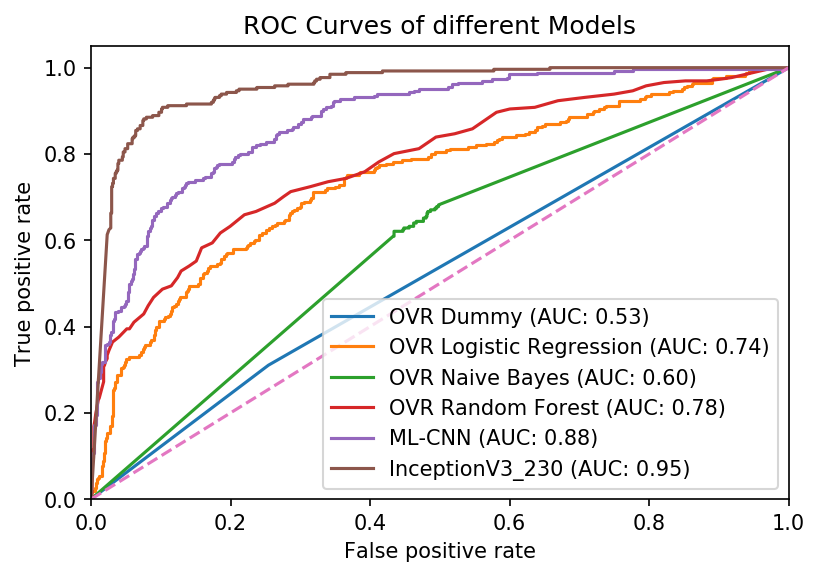

In [114]:
Compare_Multiple_ROC_Curves(y_val, y_score_dict)

# Re-visit Performance Metrics of Pre-trained Image CNN Model
Although, 'Abyssinian' and 'American' have weak recall and precision respectively, nonetheless, this model shows the strongest F1 score. On top of that, both PR curve and ROC curve perform very well against the rest.

In [115]:
# using test dataset
clf_report_inc_v3_230_test, cf_matrix_inc_v3_230_test, y_pred_inc_v3_230_test, _ = \
                                                    Image_NN_Predict(model_inc_v3_230,
                                                    X_test.reshape(input_shape), 
                                                    y_test, 
                                                    target_names=target_names,
                                                    batch_size=batch_size, 
                                                    verbose=2)

>> Predicting on neural network
              precision    recall  f1-score   support

  Abyssinian       0.99      0.67      0.80       111
    American       0.68      0.99      0.80       104
      Silkie       1.00      0.75      0.86        53
      Skinny       0.95      0.97      0.96        59

    accuracy                           0.84       327
   macro avg       0.90      0.84      0.85       327
weighted avg       0.88      0.84      0.84       327

[[ 74  36   0   1]
 [  0 103   0   1]
 [  0  12  40   1]
 [  1   1   0  57]]



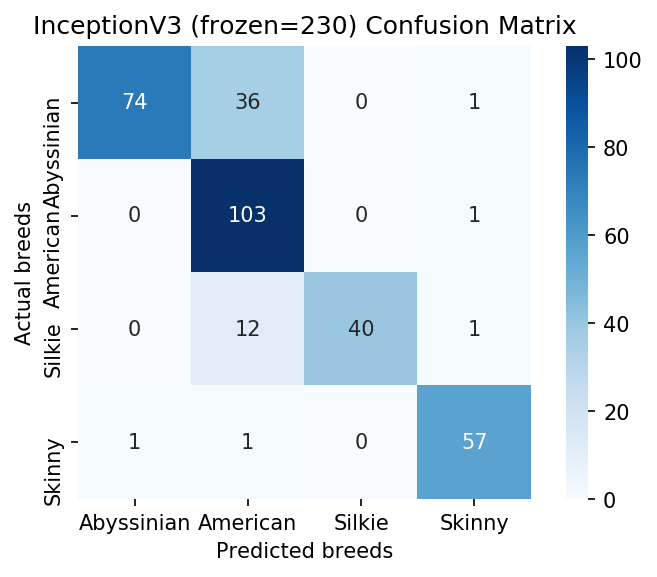

In [116]:
Show_Confusion_Matrix(cf_matrix_inc_v3_230_test, target_names, clf_name="InceptionV3 (frozen=230)")

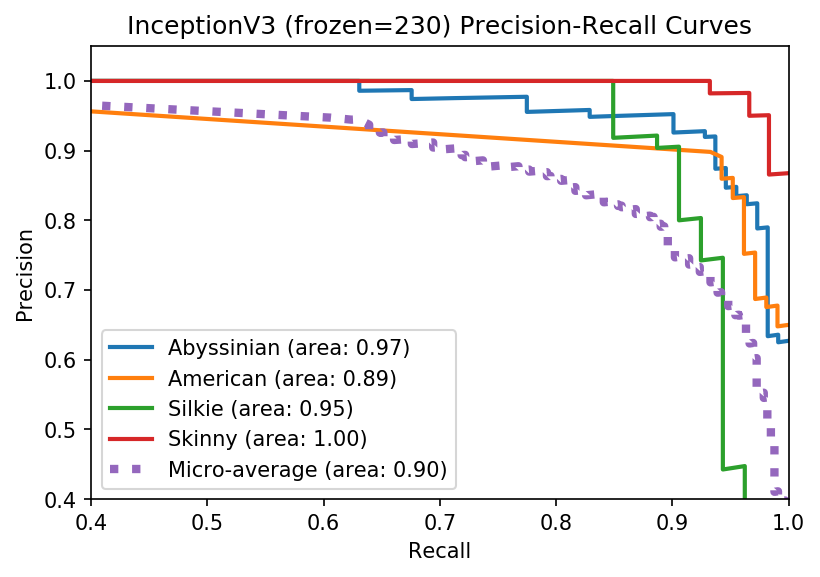

In [117]:
_ = Plot_Precision_Recall_Curve(y_test, y_pred_inc_v3_230_test, target_names, 
                                clf_name="InceptionV3 (frozen=230)", zoom_level=0.6)

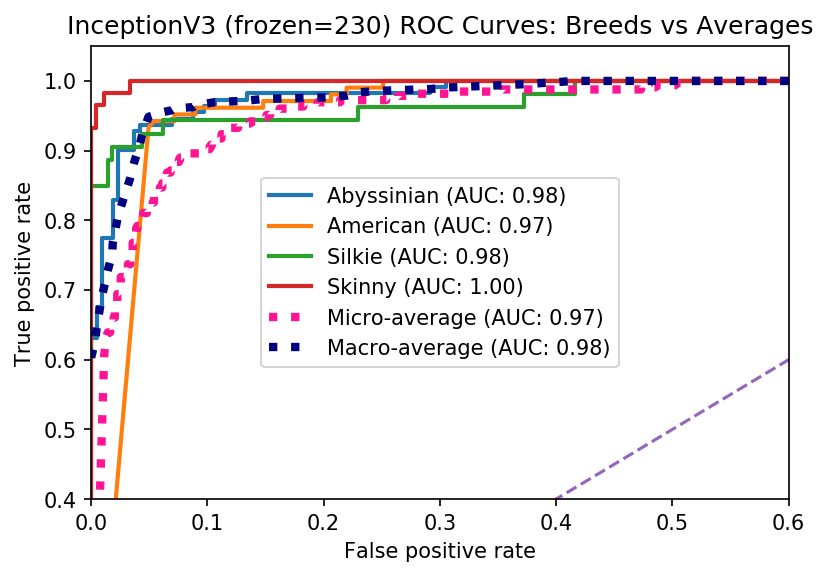

In [118]:
_ = Plot_ROC_Curve(y_test, y_pred_inc_v3_230_test, target_names, 
                   clf_name="InceptionV3 (frozen=230)", zoom_level=0.6)

# Predict using Random Images from Test Dataset

 >> Predicting on randomly selected test images


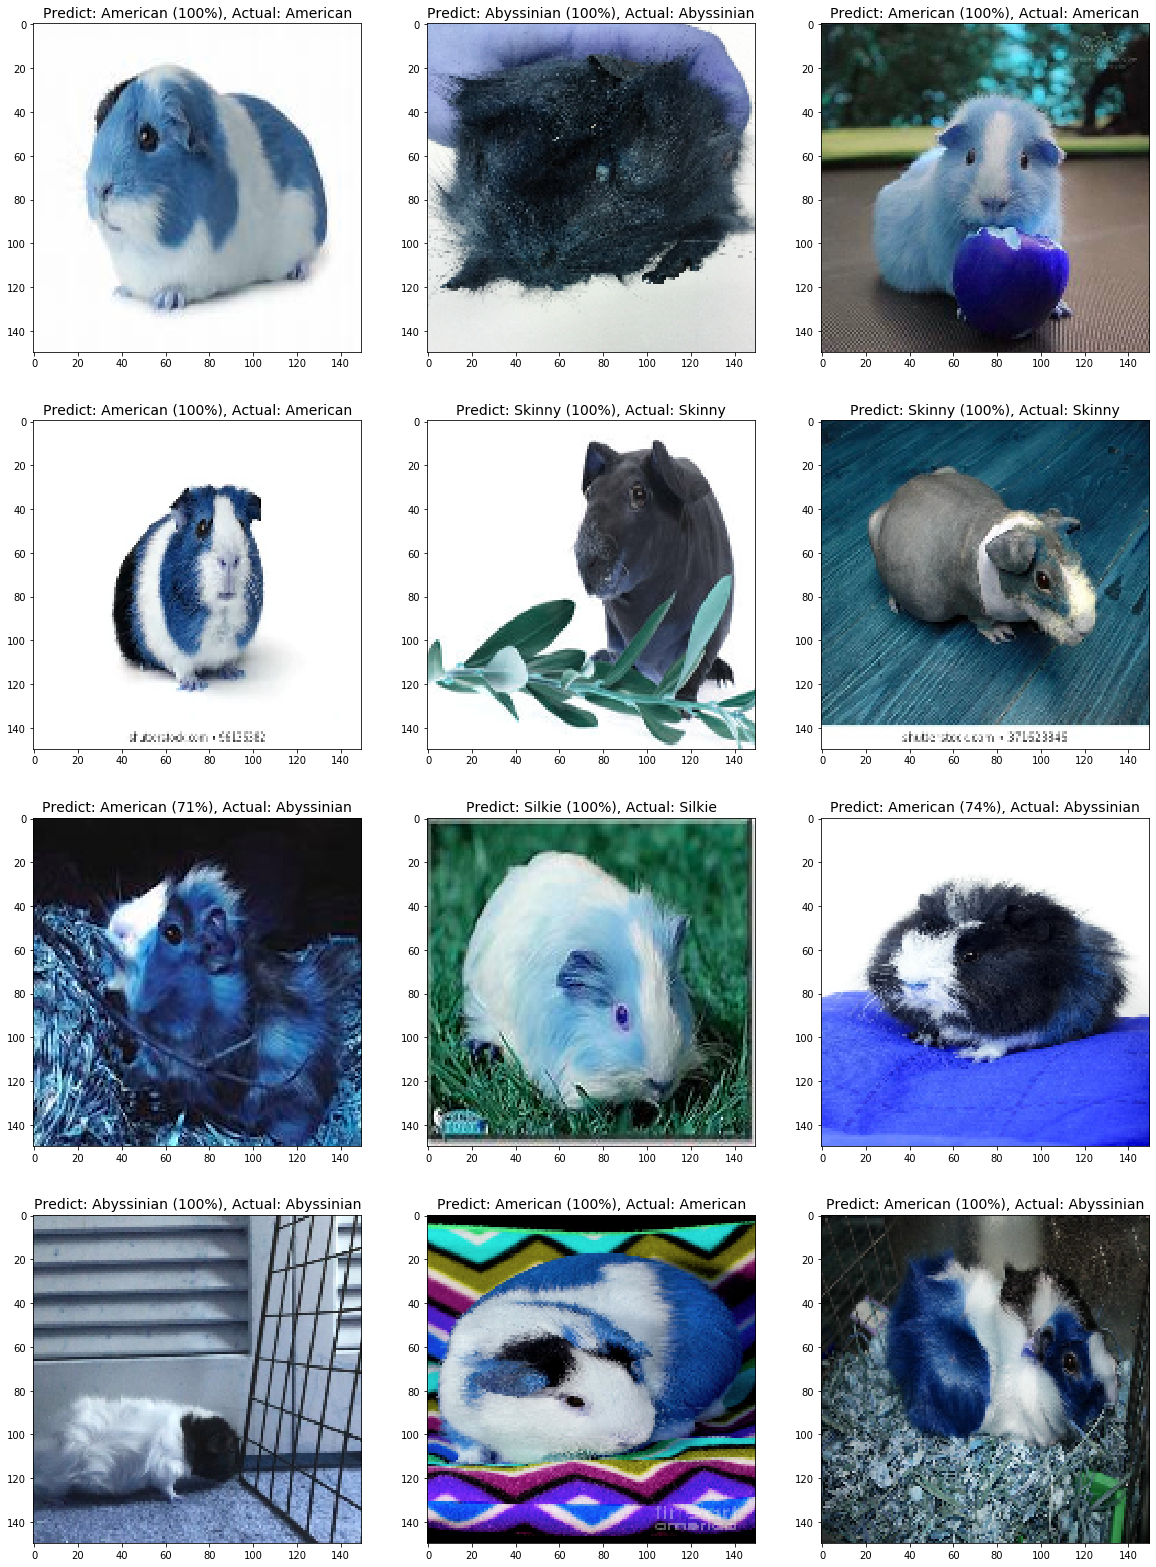

In [119]:
Image_NN_Predict_Random_Test_Images(model_inc_v3_230, X_test, y_test, target_names, input_shape, num_img=12, verbose=2)

# Predict using Sample Images in '/new_samples' subfolder
Some of these images are copied from the original image folder, others are pictures of my own cavies (those with names hyphenated in the filename).

NB: Some of the cavy breeds are not part of the training, hence the model will only know how to identify these to the closest breed it knows.

In [120]:
Image_NN_Predict_New_Samples(model_inc_v3_230, 
                             nrows=nrows, 
                             ncolumns=ncolumns, 
                             target_names=target_names,
                             sample_path='images/new_samples/')

Output hidden; open in https://colab.research.google.com to view.